In [1]:
import torch
import torchvision
import open_clip
import json
import os
import glob
import random
from collections import defaultdict
from pathlib import Path
from typing import Dict, Union
from argparse import ArgumentParser
import logging
import cv2
import numpy as np
import torch
import time
from tqdm import tqdm

import sys
sys.path.append("..")
import colormaps
from autoencoder.model import Autoencoder
from openclip_encoder import OpenCLIPNetwork
from utils import smooth, colormap_saving, vis_mask_save, polygon_to_mask, stack_mask, show_result

/datadrive/yingwei/miniconda3/envs/langsplat/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
render_img = "/datadrive/yingwei/LangSplat/dataset/lerf_ovs/teatime/output/teatime_1/train/ours_None/renders/00107.png"
gt_masked_img = "/datadrive/yingwei/LangSplat/eval_result/teatime/gt/frame_00107/apple.jpg"



Render Image Processed Min: 0.0
Render Image Processed Max: 1.0
Mask Pred Unique Values: [0 1]


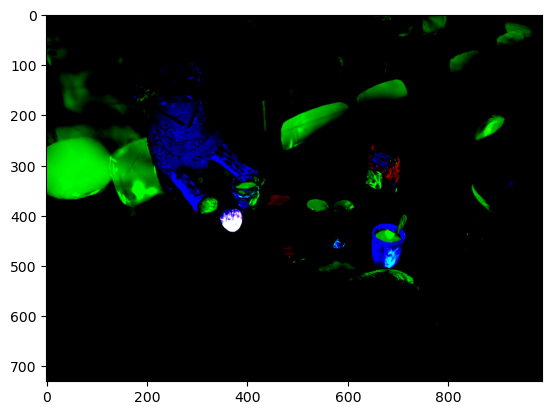

In [26]:
import torch
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

def load_image(path):
    return io.imread(path)

def normalize_image(image):
    # Normalize the image to the range [0, 1]
    image = image.astype(np.float32)
    image = (image - image.min()) / (image.max() - image.min() + 1e-9)
    return image

def preprocess_image(image):
    # Normalize to [0, 1] and then scale to [-1, 1]
    image = normalize_image(image)
    image = image * 2 - 1  # Scale to the range [-1, 1]
    image = np.clip(image, 0, 1)
    return image


def generate_mask(image, threshold):

    return (image > threshold).astype(np.uint8)

def calculate_iou(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt)
    union = np.logical_or(mask_pred, mask_gt)
    iou = np.sum(intersection) / np.sum(union)
    return iou


render_img_path = "/datadrive/yingwei/LangSplat/dataset/lerf_ovs/teatime/output/teatime_1/train/ours_None/renders/00107.png"
gt_masked_img_path = "/datadrive/yingwei/LangSplat/eval_result/teatime/gt/frame_00107/apple.jpg"
threshold = .5

# Load images
render_img = load_image(render_img_path)
gt_masked_img = load_image(gt_masked_img_path)
# Debug: Check processed image stats
# Preprocess render image
render_img_processed = preprocess_image(render_img)

print("Render Image Processed Min:", render_img_processed.min())
print("Render Image Processed Max:", render_img_processed.max())
# Generate mask from render image
mask_pred = generate_mask(render_img_processed, threshold)
# Debug: Check mask stats
print("Mask Pred Unique Values:", np.unique(mask_pred))
plt.imshow(render_img_processed)




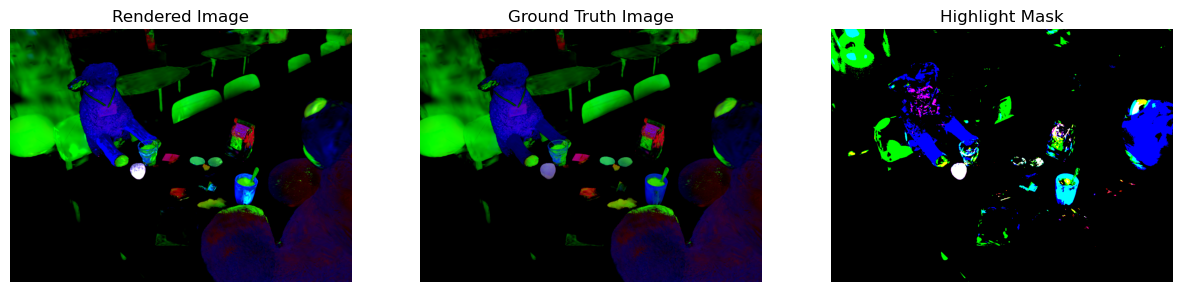

In [2]:



import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

def load_image(path):
    return io.imread(path)

def generate_highlight_mask(rendered_img, gt_img):
    # Generate a binary mask where the rendered image has higher values than the GT image
    mask = (rendered_img > gt_img).astype(np.uint8) * 255
    return mask

def plot_images(rendered_img, gt_img, mask):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Rendered Image")
    plt.imshow(rendered_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Image")
    plt.imshow(gt_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Highlight Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

def main():

    rendered_img_path = "/datadrive/yingwei/LangSplat/eval/test/00107.png"
    gt_img_path = "/datadrive/yingwei/LangSplat/eval/test/00107_original.png"

    # Load images
    rendered_img = load_image(rendered_img_path)
    gt_img = load_image(gt_img_path)

    # Ensure the images are in the range [0, 255]
    rendered_img = rendered_img.astype(np.uint8)
    gt_img = gt_img.astype(np.uint8)

    # Generate the highlight mask
    mask = generate_highlight_mask(rendered_img, gt_img)

    # Plot the images and the mask
    plot_images(rendered_img, gt_img, mask)

if __name__ == "__main__":
    main()



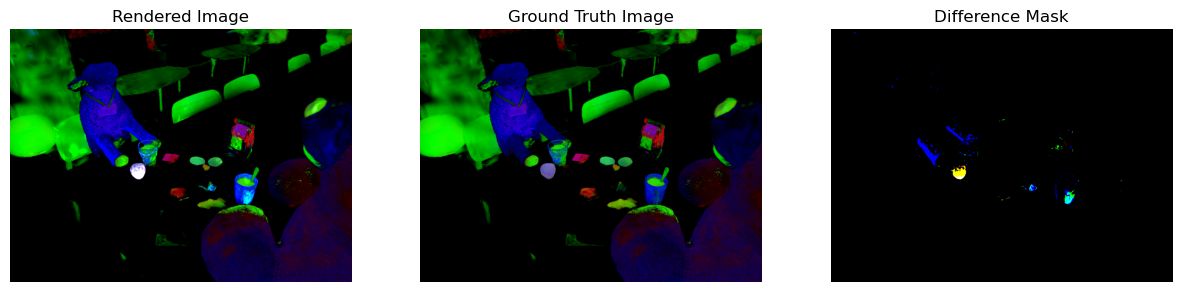

In [11]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

def load_image(path):
    return io.imread(path)

def generate_difference_mask(rendered_img, gt_img, threshold):
    # Compute the absolute difference between the rendered image and the GT image
    diff = np.abs(rendered_img.astype(np.float32) - gt_img.astype(np.float32))
    
    # Generate a binary mask based on the threshold
    mask = (diff > threshold).astype(np.uint8) * 255
    return mask

def plot_images(rendered_img, gt_img, mask):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Rendered Image")
    plt.imshow(rendered_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Image")
    plt.imshow(gt_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Difference Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

def main():
    rendered_img_path = "/datadrive/yingwei/LangSplat/eval/test/00107.png"
    gt_img_path = "/datadrive/yingwei/LangSplat/eval/test/00107_original.png"
    threshold = 120  # You can adjust this threshold based on your needs


    # Load images
    rendered_img = load_image(rendered_img_path)
    gt_img = load_image(gt_img_path)

    # Ensure the images are in the range [0, 255]
    rendered_img = rendered_img.astype(np.uint8)
    gt_img = gt_img.astype(np.uint8)

    # Generate the difference mask
    mask = generate_difference_mask(rendered_img, gt_img, threshold)

    # Plot the images and the mask
    plot_images(rendered_img, gt_img, mask)

if __name__ == "__main__":
    main()
